# Simulating NLOS captures with mitransient

## Overview
<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>Import `mitransient` and configure it for NLOS scenes</li>
  <li>Setup a NLOS scene, including the relay wall, laser, camera and hidden geometry</li>
  <li>Visualize the output capture</li>
</ul>

</div>

In this tutorial, you will use mitransient to simulate a non-line-of-sight (NLOS) scene with mitransient. If you are not familiar, NLOS imaging algorithm use indirect light scattered in the scene to reconstruct hidden objects, for example around a corner. For this example, we will target a Z-shaped geometry defined in `Z.obj`. The scene's camera will not directly capture light from the Z object, but instead capture indirect light that has bounced on a rectangular *relay wall*. The key elements in the scene will be:
1. The **hidden Z-shaped object**
2. The **relay wall**, defined with the `rectangle` plugin, which contains a `nlos_capture_meter` (a **sensor** to measure indirect light)
3. A **laser source** that illuminates the relay wall. We will show how to position and orient this source so that it illuinates points on the relay wall

### Importing `mitransient`
Before importing `mitransient`, you need to import Mitsuba 3 and set a variant (here we use `llvm_ad_rgb`). Only if you want to use more variants, you will need to compile Mitsuba 3 (not `mitransient`) yourself. And you will need to add the compilation folder to the `PYTHONPATH` (see the commented code for how to do that).

<div class="admonition important alert alert-block alert-warning">

For many cases, `mitransient` requires the use of a `llvm_*` or `cuda_*` variant, so we don't recommend using `scalar_rgb`. It will work with any `llvm_*` or `cuda_*` variant, and for most use cases `llvm_ad_rgb` or `cuda_ad_rgb` is enough. **Maybe if you plan to do NLOS simulations it can be worth to do `llvm_mono` or `cuda_mono`, which only uses one wavelength instead of three RGB channels, and thus is faster.**

</div>

In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
mi.set_variant('llvm_ad_rgb')

import mitransient as mitr

### Setup the NLOS scene

In this tutorial you will learn how to prepare a NLOS scene using our library. We will do it following a programmatically way defining each component independently. Here we do it with `mi.load_dict`, but we also provide a `nlos_Z.xml` file which can be loaded with `mi.load_file` and gives the same results. Note that the conversion from XML and dictionaries is fairly straightforward.

<div class="admonition important alert alert-block alert-success">

If you want to learn more about the parameters of each plugin (geometry, emitter, transient_film, etc.), you can check [Mitsuba 3's documentation](https://mitsuba.readthedocs.io/en/stable/src/plugin_reference.html), and our documentation ([integrators](https://mitransient.readthedocs.io/en/latest/generated/plugin_reference/section_integrators.html), [films](https://mitransient.readthedocs.io/en/latest/generated/plugin_reference/section_films.html), [sensors](https://mitransient.readthedocs.io/en/latest/generated/plugin_reference/section_sensors.html), [other functions](https://mitransient.readthedocs.io/en/latest/src/other.html))

</div>

In [2]:
# Load the geometry of the hidden scene
geometry = mi.load_dict(
    {
        "type": "obj",
        "filename": "./Z.obj",
        "to_world": mi.ScalarTransform4f.translate([0.0, 0.0, 1.0]),
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
    }
)

# Load the emitter (laser) of the scene
emitter = mi.load_dict(
    {
        "type": "projector",
        "irradiance": 100.0,
        "fov": 0.2,
        "to_world": mi.ScalarTransform4f.translate([-0.5, 0.0, 0.25]),
    }
)

# Define the transient film which store all the data
transient_film = mi.load_dict(
    {
        "type": "transient_hdr_film",
        "width": 64,
        "height": 64,
        "temporal_bins": 300,
        "bin_width_opl": 0.006,
        "start_opl": 1.85,
        "rfilter": {"type": "box"},
    }
)

# Define the sensor of the scene
nlos_sensor = mi.load_dict(
    {
        "type": "nlos_capture_meter",
        "sampler": {"type": "independent", "sample_count": 25000},
        "account_first_and_last_bounces": False,
        "sensor_origin": [-0.5, 0.0, 0.25],
        "transient_film": transient_film,
    }
)

# Load the relay wall. This includes the custom "nlos_capture_meter" sensor which allows to setup measure points directly on the shape and importance sample paths going through the relay wall.
relay_wall = mi.load_dict(
    {
        "type": "rectangle",
        "bsdf": {"type": "diffuse", "reflectance": 1.0},
        "nlos_sensor": nlos_sensor,
    }
)

# Finally load the integrator
integrator = mi.load_dict(
    {
        "type": "transient_nlos_path",
        "nlos_laser_sampling": True,
        "nlos_hidden_geometry_sampling": True,
        "nlos_hidden_geometry_sampling_do_rroulette": False,
        "temporal_filter": "box",
    }
)

In [3]:
# Assemble the final scene
scene = mi.load_dict({
    'type' : 'scene',
    'geometry' : geometry,
    'emitter' : emitter,
    'relay_wall' : relay_wall,
    'integrator' : integrator
})

In [4]:
# Now we focus the emitter to irradiate one specific pixel of the "relay wall"
pixel = mi.Point2f(32, 32)
mitr.nlos.focus_emitter_at_relay_wall_pixel(pixel, relay_wall, emitter)

### Setup the `NLOS transient` integrator

In [5]:
# Prepare transient integrator for transient path tracing
# It does the work to initialize the scene before path tracing
transient_integrator = scene.integrator()
# sensor=0 just tells it to use the first sensor in the scene
# (in case there is more than one sensor in the XML file)
transient_integrator.prepare_transient(scene, sensor=0)

### Render the scene in steady and transient domain

In [6]:
data_steady, data_transient = transient_integrator.render(scene)

<div class="admonition important alert alert-block alert-warning">
Mitsuba 3 and `mitransient` work with Dr.JIT, which has lazy evaluation.
That means the actual image/video will not be computed until you use it.
As such, this cell should take &lt;1s to execute
</div>

The result is:
1) A steady state image `data_steady` with dimensions (width, height, channels)
2) A transient image `data_transient` with dimensions (width, height, time, channels)

`data_steady` would be the result of a conventional (non-transient) render i.e. `data_steady = data_transient.sum(axis=2)`

### Visualize the steady and transient image
We provide different functions so you can visualize your data in a Jupyter notebook

### Visualize the transient image

The important part for NLOS imaging is `data_transient`, which contains the time-resolved indirect illumination. Here we show how to visualize it.

In [7]:
'''
data_transient is a 4D array represented as a Dr.JIT's TensorXf class.
It is very similar to a numpy array (in fact, you can convert between
the two by using np.array(data_transient))
'''
print(data_transient.__class__.__name__)
# The channels represent (x, y, time, rgb)
print(data_transient.shape)

TensorXf
(64, 64, 300, 3)


### Plot radiance at one pixel over time

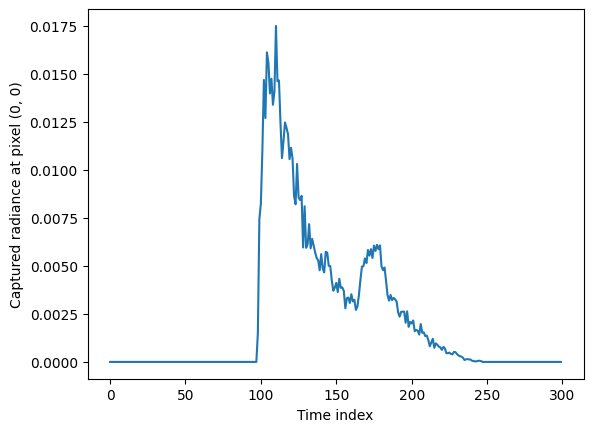

In [8]:
import numpy as np
import matplotlib.pyplot as plt

i, j = 0, 0

# There are two main ways of plotting data_transient
# The first one is to plot a single pixel's time-resolved response
plt.plot(np.array(data_transient)[i, j, :, 0])
plt.xlabel('Time index')
plt.ylabel(f'Captured radiance at pixel ({i}, {j})')
plt.show()

### Plot radiance at all pixels in the relay wall at one time instant

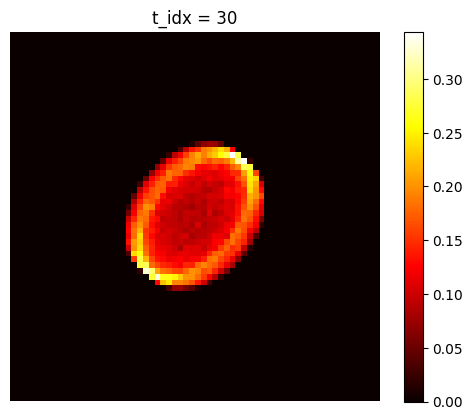

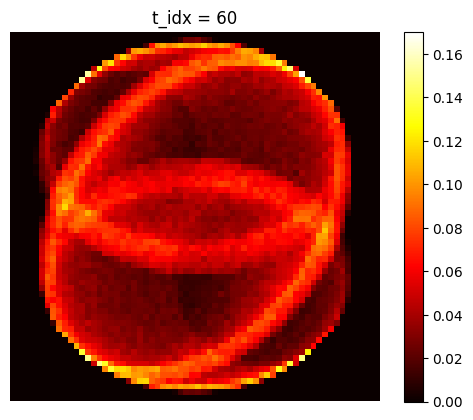

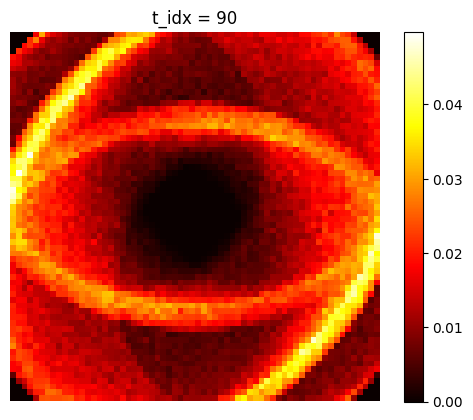

In [9]:
# The second one is to plot a frame of the transient video
# To understand this image, you can look at the paper:
# Non-Line-of-Sight Transient Rendering, Figure 4

def plot_time_instant(t):
    plt.imshow(np.fliplr(np.array(data_transient)[:, :, t, 0].T), cmap='hot')
    plt.colorbar()
    plt.axis('off')
    plt.xlabel('Relay wall X')
    plt.ylabel('Relay wall Y')
    plt.title(f't_idx = {t}')
    plt.show()

plot_time_instant(30)
plot_time_instant(60)
plot_time_instant(90)

In [10]:
# mitransient offers a utility function to show videos

mitr.vis.show_video(np.moveaxis(data_transient, 0, 1), 2)